In [10]:
import jax
import jax.numpy as jnp
from utils.io import load_obj, create_triangle_arrays

In [11]:
#load object

square_path = "objects/square.obj"
sphere_path = "objects/sphere.obj"
cube_path = "objects/cube.obj"
cylinder_path = "objects/cylinder.obj"
rabbit = "objects/rabbit.obj"
carrot = "objects/carrot.obj"
plane = "objects/plane.obj"
squirrel = "objects/squirrel.obj"
tree = "objects/broad_deciduous_tree_green_leaves.obj"
ant = "objects/ant.obj"
fireball = "objects/fireball.obj"
dragon = "objects/dragon.obj"
crawler = "objects/crawler.obj"


file_path = carrot

In [12]:
vertices, faces = load_obj(file_path)
triangles = create_triangle_arrays(vertices, faces)
triangles

{'vertex_1': Array([[-2.8973150e+00,  1.3289683e+01,  3.4134369e+00],
        [-2.3006700e-01,  1.0752763e+01,  7.9705000e-02],
        [ 1.0858000e-02,  1.0835635e+01, -2.0495400e-01],
        [ 3.9818701e-01,  1.3382749e+01,  1.9371000e-01],
        [-9.4076000e-02,  1.3273426e+01,  1.0305270e+00],
        [-1.1231000e-01,  1.4998567e+01,  5.8584201e-01],
        [-2.2138929e+00,  1.5225525e+01,  1.4856040e+00],
        [ 4.8523278e+00,  1.4013837e+01, -2.5449699e-01],
        [ 4.2591538e+00,  1.5081957e+01, -6.1435997e-01],
        [ 3.4277151e+00,  1.4238135e+01,  4.9385000e-02],
        [ 2.4769101e+00,  1.5459887e+01, -1.6992199e-01],
        [ 6.9417101e-01,  1.4996229e+01,  4.6680000e-01],
        [ 7.6956099e-01,  1.3632153e+01,  5.1836401e-01],
        [ 1.6574600e-01,  1.0752763e+01,  0.0000000e+00],
        [ 2.3400590e+00,  1.4351068e+01, -4.0018039e+00],
        [ 1.8073220e+00,  1.5251101e+01, -3.5135851e+00],
        [ 2.5343901e-01,  1.0752763e+01, -1.7044900e-01],
  

In [13]:
from accelerators.bvh import build_bvh

bvh = build_bvh(triangles, max_leaf_size=4)

In [14]:
bvh

BVH(aabb_mins=Array([[-1.6072799e-01,  1.6136000e-02, -3.1853300e-01],
       [ 1.5684400e-01,  1.6136000e-02, -3.1853300e-01],
       [-6.3295299e-01,  1.6136000e-02, -2.2523700e-01],
       [-6.3295299e-01,  1.6136000e-02, -3.1853300e-01],
       [-6.3295299e-01,  1.6136000e-02, -3.1853300e-01],
       [-5.2025598e-01,  9.7658002e-01, -6.2493402e-01],
       [-6.7713998e-02,  9.8292202e-01, -5.1133901e-01],
       [-5.2025598e-01,  9.7658002e-01, -6.2493402e-01],
       [ 3.8140100e-01,  1.0135410e+00, -2.2523700e-01],
       [-6.3295299e-01,  9.7658002e-01, -6.2493402e-01],
       [-6.3295299e-01,  9.7658002e-01, -6.2493402e-01],
       [-6.3295299e-01,  9.7658002e-01, -6.2493402e-01],
       [-6.3295299e-01,  1.6136000e-02, -6.2493402e-01],
       [-3.8213500e-01,  9.8292202e-01, -6.2493402e-01],
       [-7.5722998e-01,  1.0198820e+00, -6.3528699e-01],
       [-1.0201150e+00,  2.9518290e+00, -9.0206498e-01],
       [-1.0201150e+00,  1.0198820e+00, -9.0206498e-01],
       [-1.020115

In [15]:
from tests.test_bvh import debug_print_bvh

debug_print_bvh(bvh)

Node 110:
  AABB:
    Min bounds   : [-4.933327  0.016136 -4.001804]
    Max bounds   : [ 4.852329 16.596111  3.413437]
    Centroid     : [-0.04049921  8.306124   -0.2941835 ]
    Diagonal     : [ 9.785656 16.579975  7.415241]
    Surface Area : 715.50684
    Largest dim (split axis): 1
  Internal node: left = 54, right = 109
  Node 54:
  AABB:
    Min bounds   : [-1.189105  0.016136 -1.189105]
    Max bounds   : [ 1.189105 10.860138  1.189105]
    Centroid     : [0.       5.438137 0.      ]
    Diagonal     : [ 2.37821  10.844002  2.37821 ]
    Surface Area : 114.469025
    Largest dim (split axis): 1
    Internal node: left = 26, right = 53
    Node 26:
  AABB:
    Min bounds   : [-1.020115  0.016136 -0.902065]
    Max bounds   : [0.77498  5.935621 0.902065]
    Centroid     : [-0.1225675  2.9758785  0.       ]
    Diagonal     : [1.795095  5.9194846 1.80413  ]
    Surface Area : 49.08828
    Largest dim (split axis): 1
      Internal node: left = 12, right = 25
      Node 12:
  AAB

In [16]:
from accelerators.bvh import intersect_bvh

ray_origin = jnp.array([0.0, 0.0, -5.0])
ray_direction = jnp.array([0.0, 0.0, 1.0])
t_max = 1e10
isec = intersect_bvh(ray_origin, ray_direction, bvh, triangles, t_max)

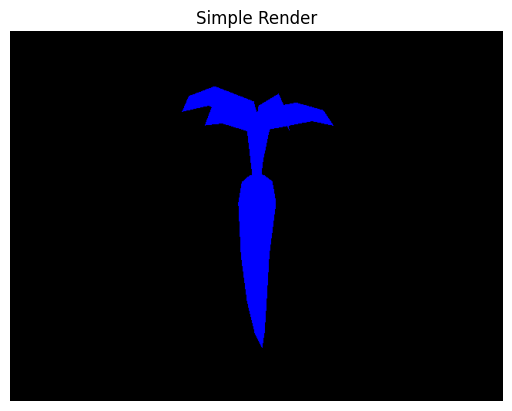

In [17]:
from base.renderer import create_default_camera, render

# Create a default camera that frames the entire object.
width = 640
height = 480
fov = 45.0  # vertical field-of-view in degrees
camera = create_default_camera(triangles, width, height, fov)

# Render the image.
image = render(triangles, bvh, camera)

# Display the image using matplotlib.
import matplotlib.pyplot as plt

plt.imshow(image)
plt.title("Simple Render")
plt.axis("off")
plt.show()